# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

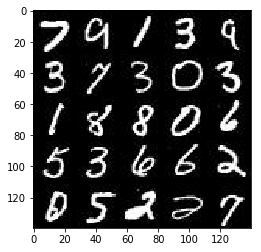

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

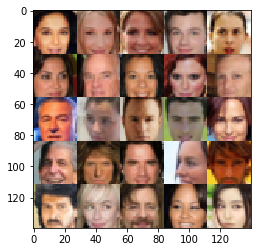

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def leaky_relu(tensor, alpha=0.2):
    """
    Layer for leaky relu
    :param tensor: Tensor of input
    :param alpha: the leaking factor
    :return: export
    """
    return tf.maximum(alpha * tensor, tensor)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #print('d image shape', images.shape)
        #28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = leaky_relu(x1)
        
        #14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = leaky_relu(bn2)
        
        #7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = leaky_relu(bn3)
        
        #print('d relu3', relu3.shape)
        #4x4x256
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not(is_train)):
        # fully connected layer
        #print('g input z', z.shape)
        x1 = tf.layers.dense(z, 7*7*512)
        
        # reshape for convolution
        x2 = tf.reshape(x1, (-1, 7, 7, 512))
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = leaky_relu(bn2)
        #print('g relu2 shape', relu2.shape)
        
        # 7x7x512
        x3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = leaky_relu(bn3)
        
        # 14x14x256
        x4 = tf.layers.conv2d_transpose(relu3, 128, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = leaky_relu(bn4)
        #print('g relu4 shape', relu4.shape)
        
        # 24x24x128
        #print('out_channel_dim', out_channel_dim)
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding='same')
        #print('g logits', logits.shape)
        
        # 28x28xout_channel_dim
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Smooth factor
    smooth = 0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.multiply(tf.ones_like(d_model_real), smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    n = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                n += 1
                # Fix the range from [-0.5, 0.5] to [-1, 1]
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate
                                                    })
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate
                                                    })
                if n % 5 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Steps {}".format(n),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if n % 20 == 0:
                    show_generator_output(sess, 4, input_z, len(data_image_mode), data_image_mode)
        print('Finished Training. The result: ')
        show_generator_output(sess, 4, input_z, len(data_image_mode), data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Steps 5 Discriminator Loss: 0.5464 Generator Loss: 2.6655
Steps 10 Discriminator Loss: 0.4397 Generator Loss: 3.8737
Steps 15 Discriminator Loss: 0.3903 Generator Loss: 3.8779
Steps 20 Discriminator Loss: 0.3532 Generator Loss: 5.7998


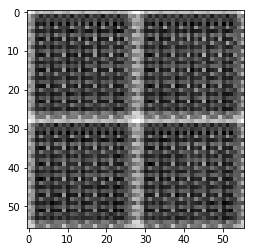

Steps 25 Discriminator Loss: 0.3874 Generator Loss: 3.4058
Steps 30 Discriminator Loss: 0.6401 Generator Loss: 5.2825
Steps 35 Discriminator Loss: 0.4161 Generator Loss: 6.0284
Steps 40 Discriminator Loss: 0.4210 Generator Loss: 4.5058


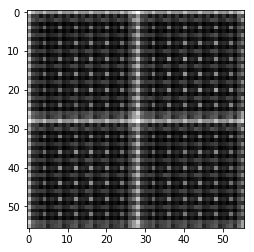

Steps 45 Discriminator Loss: 0.3718 Generator Loss: 4.6871
Steps 50 Discriminator Loss: 0.3605 Generator Loss: 4.4627
Steps 55 Discriminator Loss: 0.3572 Generator Loss: 4.6178
Steps 60 Discriminator Loss: 0.4792 Generator Loss: 2.3359


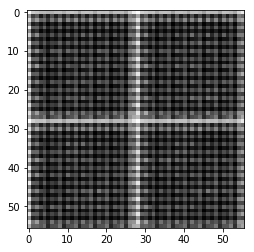

Steps 65 Discriminator Loss: 0.5296 Generator Loss: 8.7746
Steps 70 Discriminator Loss: 1.4132 Generator Loss: 6.4304
Steps 75 Discriminator Loss: 3.5713 Generator Loss: 7.1340
Steps 80 Discriminator Loss: 1.0350 Generator Loss: 2.4483


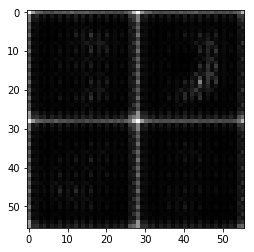

Steps 85 Discriminator Loss: 2.3653 Generator Loss: 0.2319
Steps 90 Discriminator Loss: 1.3772 Generator Loss: 0.7923
Steps 95 Discriminator Loss: 0.7830 Generator Loss: 1.7574
Steps 100 Discriminator Loss: 1.2104 Generator Loss: 1.7112


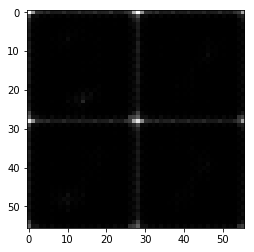

Steps 105 Discriminator Loss: 1.1151 Generator Loss: 0.9689
Steps 110 Discriminator Loss: 1.0349 Generator Loss: 1.4608
Steps 115 Discriminator Loss: 1.1944 Generator Loss: 0.7558
Steps 120 Discriminator Loss: 1.0580 Generator Loss: 1.3814


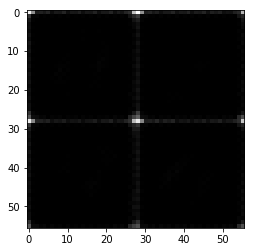

Steps 125 Discriminator Loss: 1.1499 Generator Loss: 0.8163
Steps 130 Discriminator Loss: 1.1741 Generator Loss: 1.2720
Steps 135 Discriminator Loss: 1.2248 Generator Loss: 0.6926
Steps 140 Discriminator Loss: 1.3388 Generator Loss: 1.0618


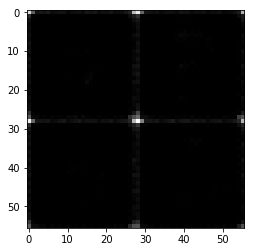

Steps 145 Discriminator Loss: 1.3201 Generator Loss: 0.6168
Steps 150 Discriminator Loss: 1.1035 Generator Loss: 1.5034
Steps 155 Discriminator Loss: 1.5447 Generator Loss: 0.4250
Steps 160 Discriminator Loss: 1.2351 Generator Loss: 1.1754


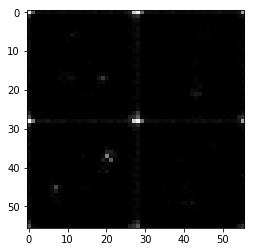

Steps 165 Discriminator Loss: 1.0712 Generator Loss: 1.5559
Steps 170 Discriminator Loss: 1.0858 Generator Loss: 0.9391
Steps 175 Discriminator Loss: 1.1541 Generator Loss: 0.8136
Steps 180 Discriminator Loss: 1.0926 Generator Loss: 1.4263


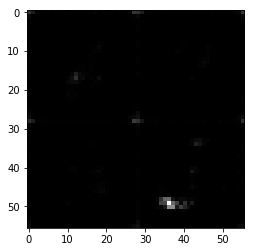

Steps 185 Discriminator Loss: 1.0932 Generator Loss: 0.8338
Steps 190 Discriminator Loss: 1.0063 Generator Loss: 1.2383
Steps 195 Discriminator Loss: 1.0469 Generator Loss: 1.0612
Steps 200 Discriminator Loss: 1.5265 Generator Loss: 0.4386


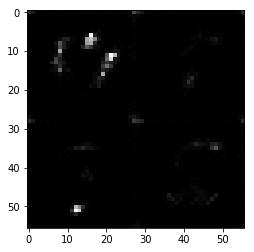

Steps 205 Discriminator Loss: 1.0974 Generator Loss: 1.2985
Steps 210 Discriminator Loss: 1.0377 Generator Loss: 0.9386
Steps 215 Discriminator Loss: 1.2617 Generator Loss: 1.8022
Steps 220 Discriminator Loss: 0.9849 Generator Loss: 1.1195


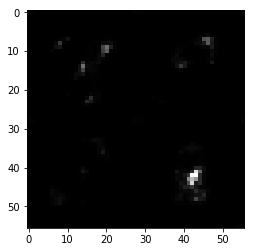

Steps 225 Discriminator Loss: 1.0648 Generator Loss: 1.6146
Steps 230 Discriminator Loss: 1.1382 Generator Loss: 0.7672
Steps 235 Discriminator Loss: 1.0354 Generator Loss: 1.1197
Steps 240 Discriminator Loss: 1.0226 Generator Loss: 1.1411


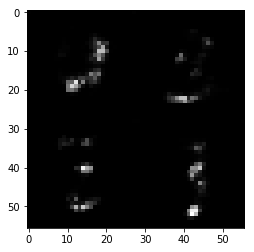

Steps 245 Discriminator Loss: 1.3390 Generator Loss: 0.5247
Steps 250 Discriminator Loss: 0.9594 Generator Loss: 1.1439
Steps 255 Discriminator Loss: 0.9311 Generator Loss: 1.3114
Steps 260 Discriminator Loss: 1.1039 Generator Loss: 0.8066


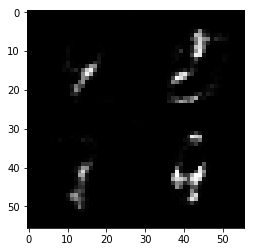

Steps 265 Discriminator Loss: 0.9066 Generator Loss: 1.3185
Steps 270 Discriminator Loss: 1.2614 Generator Loss: 0.6109
Steps 275 Discriminator Loss: 1.0241 Generator Loss: 1.0066
Steps 280 Discriminator Loss: 0.9980 Generator Loss: 1.5344


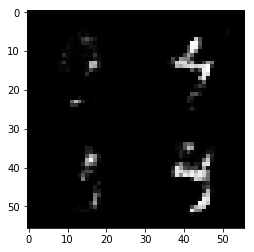

Steps 285 Discriminator Loss: 1.1262 Generator Loss: 0.8741
Steps 290 Discriminator Loss: 0.9413 Generator Loss: 1.1886
Steps 295 Discriminator Loss: 1.1145 Generator Loss: 0.8185
Steps 300 Discriminator Loss: 0.9272 Generator Loss: 1.5994


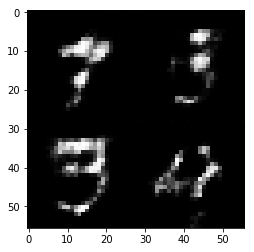

Steps 305 Discriminator Loss: 1.0959 Generator Loss: 0.7707
Steps 310 Discriminator Loss: 1.0133 Generator Loss: 1.6783
Steps 315 Discriminator Loss: 1.0292 Generator Loss: 0.9155
Steps 320 Discriminator Loss: 0.9303 Generator Loss: 1.1612


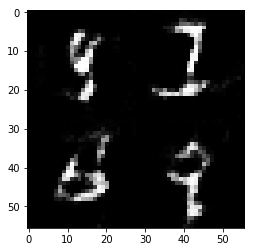

Steps 325 Discriminator Loss: 1.1393 Generator Loss: 1.7866
Steps 330 Discriminator Loss: 1.1279 Generator Loss: 0.7522
Steps 335 Discriminator Loss: 1.1985 Generator Loss: 1.7716
Steps 340 Discriminator Loss: 0.9669 Generator Loss: 1.2014


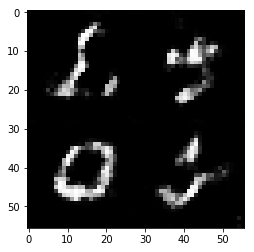

Steps 345 Discriminator Loss: 1.1358 Generator Loss: 0.7236
Steps 350 Discriminator Loss: 1.3183 Generator Loss: 1.8666
Steps 355 Discriminator Loss: 1.0001 Generator Loss: 1.1410
Steps 360 Discriminator Loss: 1.0896 Generator Loss: 1.3724


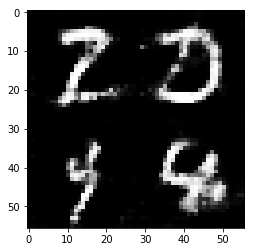

Steps 365 Discriminator Loss: 1.0576 Generator Loss: 1.0131
Steps 370 Discriminator Loss: 1.1679 Generator Loss: 0.8296
Steps 375 Discriminator Loss: 1.1768 Generator Loss: 0.6919
Steps 380 Discriminator Loss: 1.1813 Generator Loss: 1.3917


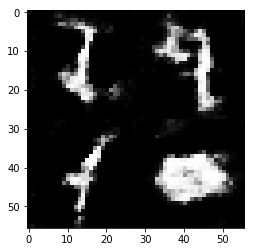

Steps 385 Discriminator Loss: 1.1958 Generator Loss: 0.6923
Steps 390 Discriminator Loss: 1.0843 Generator Loss: 1.2481
Steps 395 Discriminator Loss: 1.0131 Generator Loss: 1.1281
Steps 400 Discriminator Loss: 1.0669 Generator Loss: 1.1668


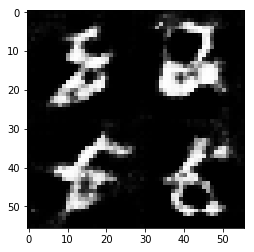

Steps 405 Discriminator Loss: 1.5602 Generator Loss: 0.4037
Steps 410 Discriminator Loss: 1.1070 Generator Loss: 1.0521
Steps 415 Discriminator Loss: 1.1115 Generator Loss: 1.2553
Steps 420 Discriminator Loss: 1.2001 Generator Loss: 0.6708


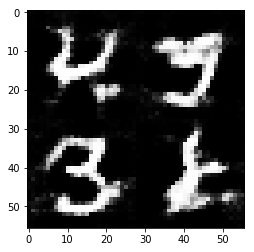

Steps 425 Discriminator Loss: 1.0692 Generator Loss: 1.0768
Steps 430 Discriminator Loss: 1.1003 Generator Loss: 1.5323
Steps 435 Discriminator Loss: 1.0703 Generator Loss: 1.0132
Steps 440 Discriminator Loss: 1.3275 Generator Loss: 0.5779


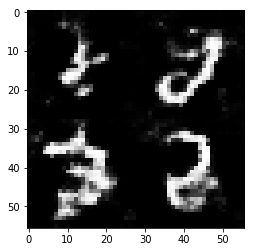

Steps 445 Discriminator Loss: 1.1103 Generator Loss: 0.8328
Steps 450 Discriminator Loss: 1.1379 Generator Loss: 1.4133
Steps 455 Discriminator Loss: 1.1866 Generator Loss: 0.7255
Steps 460 Discriminator Loss: 1.0433 Generator Loss: 1.1077


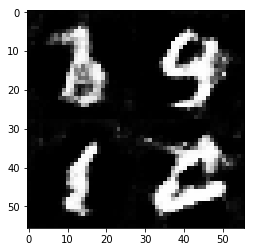

Steps 465 Discriminator Loss: 1.0985 Generator Loss: 1.6058
Steps 470 Discriminator Loss: 1.3226 Generator Loss: 0.5995
Steps 475 Discriminator Loss: 1.0765 Generator Loss: 1.4208
Steps 480 Discriminator Loss: 1.1154 Generator Loss: 0.9215


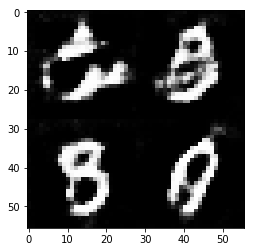

Steps 485 Discriminator Loss: 1.1892 Generator Loss: 0.7291
Steps 490 Discriminator Loss: 1.0449 Generator Loss: 1.3691
Steps 495 Discriminator Loss: 1.1233 Generator Loss: 0.9200
Steps 500 Discriminator Loss: 1.1802 Generator Loss: 0.7655


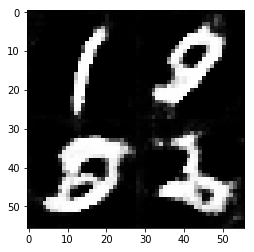

Steps 505 Discriminator Loss: 1.0023 Generator Loss: 1.3929
Steps 510 Discriminator Loss: 1.1489 Generator Loss: 1.2363
Steps 515 Discriminator Loss: 1.1449 Generator Loss: 0.8339
Steps 520 Discriminator Loss: 1.1157 Generator Loss: 1.2074


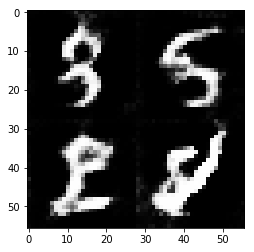

Steps 525 Discriminator Loss: 1.4135 Generator Loss: 0.5003
Steps 530 Discriminator Loss: 1.1775 Generator Loss: 0.8310
Steps 535 Discriminator Loss: 1.3271 Generator Loss: 0.5742
Steps 540 Discriminator Loss: 1.0558 Generator Loss: 1.3122


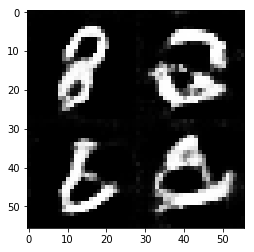

Steps 545 Discriminator Loss: 1.0825 Generator Loss: 0.9122
Steps 550 Discriminator Loss: 1.1037 Generator Loss: 0.8312
Steps 555 Discriminator Loss: 1.1129 Generator Loss: 1.5990
Steps 560 Discriminator Loss: 1.0423 Generator Loss: 1.0824


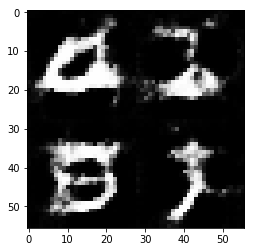

Steps 565 Discriminator Loss: 1.2258 Generator Loss: 0.7003
Steps 570 Discriminator Loss: 1.0513 Generator Loss: 1.4631
Steps 575 Discriminator Loss: 1.0810 Generator Loss: 0.9415
Steps 580 Discriminator Loss: 1.0345 Generator Loss: 1.2211


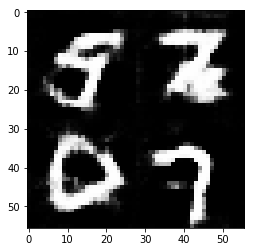

Steps 585 Discriminator Loss: 1.3586 Generator Loss: 0.5400
Steps 590 Discriminator Loss: 1.1970 Generator Loss: 0.7858
Steps 595 Discriminator Loss: 1.0398 Generator Loss: 1.2387
Steps 600 Discriminator Loss: 1.1749 Generator Loss: 1.6321


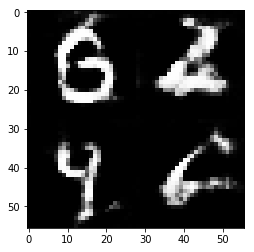

Steps 605 Discriminator Loss: 1.1204 Generator Loss: 0.7565
Steps 610 Discriminator Loss: 1.0587 Generator Loss: 0.9785
Steps 615 Discriminator Loss: 1.0946 Generator Loss: 1.1807
Steps 620 Discriminator Loss: 1.1937 Generator Loss: 1.5558


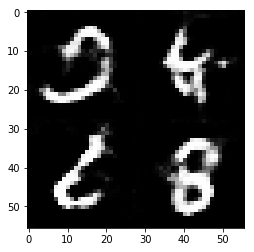

Steps 625 Discriminator Loss: 1.1259 Generator Loss: 0.7415
Steps 630 Discriminator Loss: 1.1807 Generator Loss: 1.2074
Steps 635 Discriminator Loss: 1.0977 Generator Loss: 0.9211
Steps 640 Discriminator Loss: 1.1883 Generator Loss: 1.5818


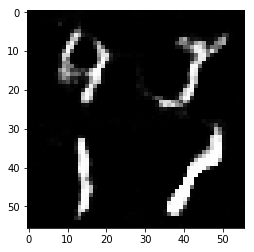

Steps 645 Discriminator Loss: 1.0679 Generator Loss: 0.9934
Steps 650 Discriminator Loss: 1.0591 Generator Loss: 0.9294
Steps 655 Discriminator Loss: 1.0462 Generator Loss: 0.9545
Steps 660 Discriminator Loss: 1.1160 Generator Loss: 1.5640


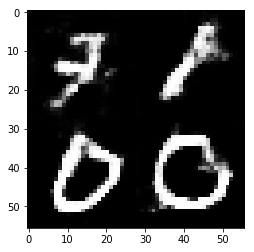

Steps 665 Discriminator Loss: 1.2114 Generator Loss: 0.6403
Steps 670 Discriminator Loss: 1.0847 Generator Loss: 0.9638
Steps 675 Discriminator Loss: 1.2816 Generator Loss: 1.7205
Steps 680 Discriminator Loss: 1.1199 Generator Loss: 0.9372


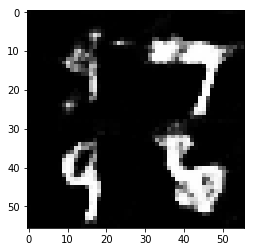

Steps 685 Discriminator Loss: 1.0620 Generator Loss: 0.9342
Steps 690 Discriminator Loss: 1.0261 Generator Loss: 1.5532
Steps 695 Discriminator Loss: 1.2524 Generator Loss: 1.8556
Steps 700 Discriminator Loss: 1.0613 Generator Loss: 0.9625


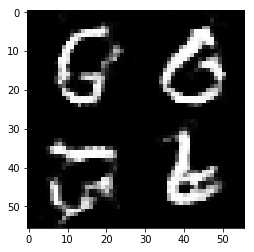

Steps 705 Discriminator Loss: 1.0743 Generator Loss: 0.8043
Steps 710 Discriminator Loss: 1.0257 Generator Loss: 1.6707
Steps 715 Discriminator Loss: 1.0691 Generator Loss: 0.8999
Steps 720 Discriminator Loss: 1.1057 Generator Loss: 1.3606


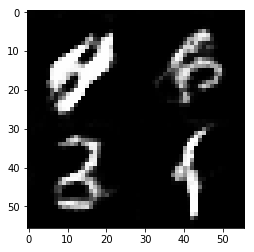

Steps 725 Discriminator Loss: 1.1902 Generator Loss: 0.6802
Steps 730 Discriminator Loss: 1.0535 Generator Loss: 1.4656
Steps 735 Discriminator Loss: 1.0646 Generator Loss: 0.9466
Steps 740 Discriminator Loss: 1.0360 Generator Loss: 0.8994


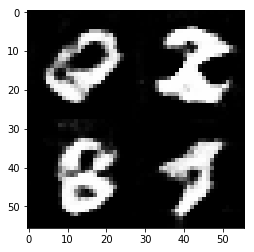

Steps 745 Discriminator Loss: 1.1462 Generator Loss: 1.3094
Steps 750 Discriminator Loss: 0.9733 Generator Loss: 1.2030
Steps 755 Discriminator Loss: 1.3145 Generator Loss: 0.5888
Steps 760 Discriminator Loss: 1.1065 Generator Loss: 0.7633


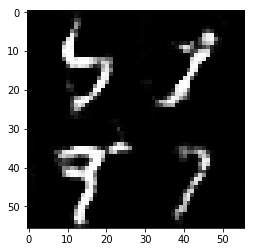

Steps 765 Discriminator Loss: 1.1366 Generator Loss: 0.8460
Steps 770 Discriminator Loss: 1.1549 Generator Loss: 1.5633
Steps 775 Discriminator Loss: 1.0290 Generator Loss: 0.8693
Steps 780 Discriminator Loss: 1.1037 Generator Loss: 0.7737


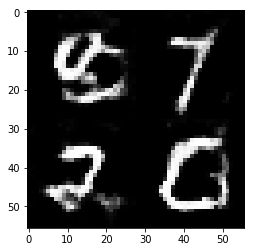

Steps 785 Discriminator Loss: 1.0813 Generator Loss: 1.8245
Steps 790 Discriminator Loss: 1.0138 Generator Loss: 1.0884
Steps 795 Discriminator Loss: 1.0894 Generator Loss: 0.8515
Steps 800 Discriminator Loss: 1.1035 Generator Loss: 1.5036


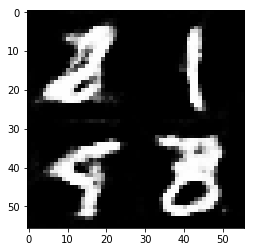

Steps 805 Discriminator Loss: 1.1633 Generator Loss: 0.7082
Steps 810 Discriminator Loss: 1.0445 Generator Loss: 1.2374
Steps 815 Discriminator Loss: 0.9305 Generator Loss: 1.0725
Steps 820 Discriminator Loss: 1.1261 Generator Loss: 1.9914


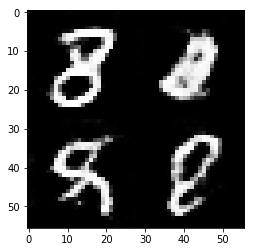

Steps 825 Discriminator Loss: 1.0657 Generator Loss: 1.2380
Steps 830 Discriminator Loss: 1.0261 Generator Loss: 0.8844
Steps 835 Discriminator Loss: 1.0628 Generator Loss: 1.6703
Steps 840 Discriminator Loss: 1.1011 Generator Loss: 1.6275


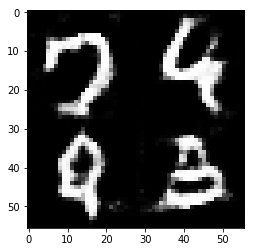

Steps 845 Discriminator Loss: 1.0452 Generator Loss: 0.8942
Steps 850 Discriminator Loss: 0.9964 Generator Loss: 1.0444
Steps 855 Discriminator Loss: 1.0270 Generator Loss: 0.8866
Steps 860 Discriminator Loss: 1.0574 Generator Loss: 1.8304


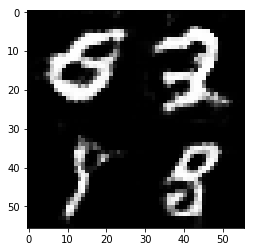

Steps 865 Discriminator Loss: 2.6410 Generator Loss: 0.1522
Steps 870 Discriminator Loss: 0.9867 Generator Loss: 1.0330
Steps 875 Discriminator Loss: 1.0076 Generator Loss: 1.0480
Steps 880 Discriminator Loss: 0.9258 Generator Loss: 1.2387


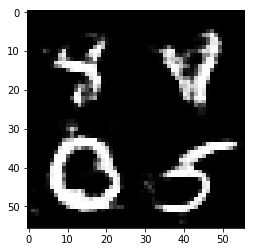

Steps 885 Discriminator Loss: 0.9590 Generator Loss: 1.2825
Steps 890 Discriminator Loss: 1.0605 Generator Loss: 0.8243
Steps 895 Discriminator Loss: 0.9960 Generator Loss: 1.0505
Steps 900 Discriminator Loss: 1.0420 Generator Loss: 1.6930


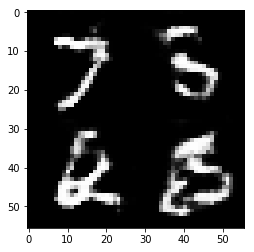

Steps 905 Discriminator Loss: 1.0907 Generator Loss: 1.8712
Steps 910 Discriminator Loss: 1.2693 Generator Loss: 0.6115
Steps 915 Discriminator Loss: 1.0974 Generator Loss: 0.9149
Steps 920 Discriminator Loss: 1.1564 Generator Loss: 0.6786


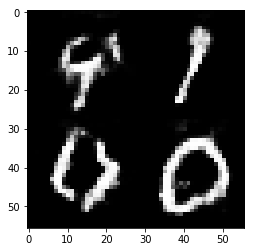

Steps 925 Discriminator Loss: 1.1248 Generator Loss: 1.8133
Steps 930 Discriminator Loss: 1.0009 Generator Loss: 0.8942
Steps 935 Discriminator Loss: 2.6640 Generator Loss: 3.0418
Finished Training. The result: 


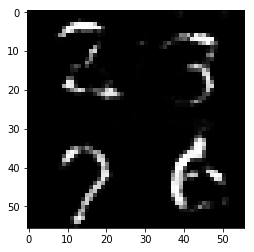

In [15]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Steps 5 Discriminator Loss: 2.3364 Generator Loss: 0.3661
Steps 10 Discriminator Loss: 1.2414 Generator Loss: 0.8541
Steps 15 Discriminator Loss: 0.5663 Generator Loss: 2.7626
Steps 20 Discriminator Loss: 0.5754 Generator Loss: 2.5460


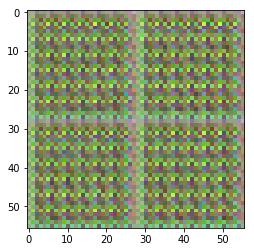

Steps 25 Discriminator Loss: 0.5993 Generator Loss: 2.6394
Steps 30 Discriminator Loss: 0.5789 Generator Loss: 2.2130
Steps 35 Discriminator Loss: 0.5490 Generator Loss: 2.5781
Steps 40 Discriminator Loss: 0.6631 Generator Loss: 2.3001


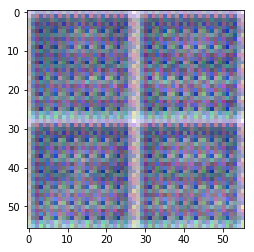

Steps 45 Discriminator Loss: 1.1151 Generator Loss: 0.8893
Steps 50 Discriminator Loss: 1.0821 Generator Loss: 3.1490
Steps 55 Discriminator Loss: 1.1277 Generator Loss: 0.7929
Steps 60 Discriminator Loss: 0.9191 Generator Loss: 1.3615


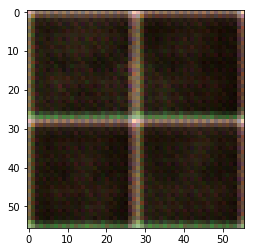

Steps 65 Discriminator Loss: 0.9211 Generator Loss: 3.2314
Steps 70 Discriminator Loss: 1.0446 Generator Loss: 1.2176
Steps 75 Discriminator Loss: 0.9498 Generator Loss: 3.2328
Steps 80 Discriminator Loss: 0.9638 Generator Loss: 1.6834


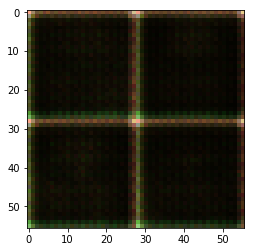

Steps 85 Discriminator Loss: 0.9419 Generator Loss: 1.0868
Steps 90 Discriminator Loss: 0.8481 Generator Loss: 1.3044
Steps 95 Discriminator Loss: 1.4682 Generator Loss: 6.3219
Steps 100 Discriminator Loss: 0.7900 Generator Loss: 2.4101


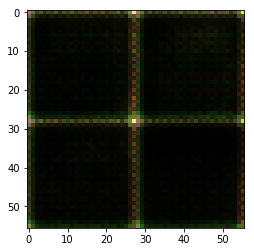

Steps 105 Discriminator Loss: 0.7216 Generator Loss: 1.4309
Steps 110 Discriminator Loss: 0.4950 Generator Loss: 3.2462
Steps 115 Discriminator Loss: 0.8263 Generator Loss: 1.4982
Steps 120 Discriminator Loss: 0.7128 Generator Loss: 2.3020


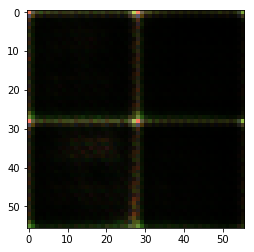

Steps 125 Discriminator Loss: 0.9634 Generator Loss: 5.3507
Steps 130 Discriminator Loss: 0.7819 Generator Loss: 1.5074
Steps 135 Discriminator Loss: 0.6155 Generator Loss: 2.7237
Steps 140 Discriminator Loss: 0.4515 Generator Loss: 3.1435


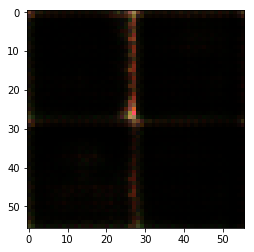

Steps 145 Discriminator Loss: 0.7105 Generator Loss: 1.4443
Steps 150 Discriminator Loss: 1.6163 Generator Loss: 5.5889
Steps 155 Discriminator Loss: 0.4782 Generator Loss: 2.5091
Steps 160 Discriminator Loss: 0.5921 Generator Loss: 1.8887


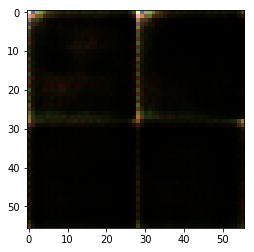

Steps 165 Discriminator Loss: 1.1438 Generator Loss: 0.6893
Steps 170 Discriminator Loss: 1.0362 Generator Loss: 0.8727
Steps 175 Discriminator Loss: 0.9480 Generator Loss: 1.0878
Steps 180 Discriminator Loss: 0.9408 Generator Loss: 0.9992


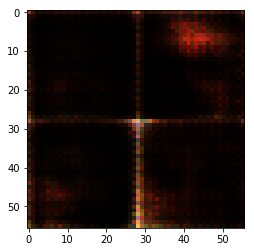

Steps 185 Discriminator Loss: 0.6591 Generator Loss: 1.6154
Steps 190 Discriminator Loss: 0.7128 Generator Loss: 1.3948
Steps 195 Discriminator Loss: 0.8074 Generator Loss: 5.0727
Steps 200 Discriminator Loss: 0.8446 Generator Loss: 1.0381


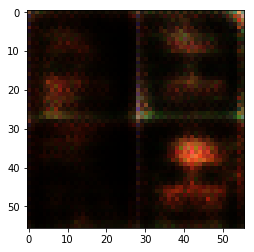

Steps 205 Discriminator Loss: 0.4959 Generator Loss: 2.4932
Steps 210 Discriminator Loss: 1.9647 Generator Loss: 4.7784
Steps 215 Discriminator Loss: 1.4362 Generator Loss: 4.8704
Steps 220 Discriminator Loss: 1.6156 Generator Loss: 0.4428


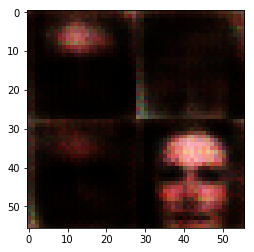

Steps 225 Discriminator Loss: 0.6706 Generator Loss: 2.1443
Steps 230 Discriminator Loss: 0.4720 Generator Loss: 4.5999
Steps 235 Discriminator Loss: 0.7656 Generator Loss: 1.8287
Steps 240 Discriminator Loss: 1.4617 Generator Loss: 3.7403


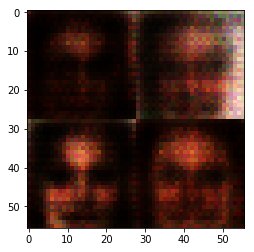

Steps 245 Discriminator Loss: 1.2486 Generator Loss: 0.6663
Steps 250 Discriminator Loss: 0.9035 Generator Loss: 2.0716
Steps 255 Discriminator Loss: 1.1328 Generator Loss: 0.7530
Steps 260 Discriminator Loss: 0.5894 Generator Loss: 2.5914


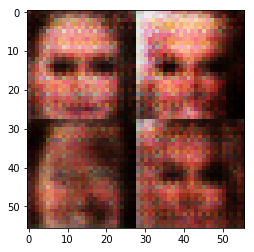

Steps 265 Discriminator Loss: 1.5763 Generator Loss: 0.4270
Steps 270 Discriminator Loss: 0.9910 Generator Loss: 1.0569
Steps 275 Discriminator Loss: 0.9397 Generator Loss: 3.3098
Steps 280 Discriminator Loss: 1.5043 Generator Loss: 0.4702


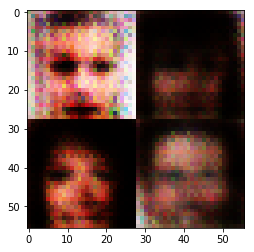

Steps 285 Discriminator Loss: 0.6893 Generator Loss: 1.6147
Steps 290 Discriminator Loss: 1.0641 Generator Loss: 2.9871
Steps 295 Discriminator Loss: 0.7450 Generator Loss: 1.5737
Steps 300 Discriminator Loss: 0.6113 Generator Loss: 2.2632


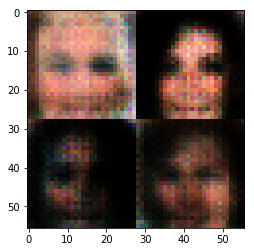

Steps 305 Discriminator Loss: 1.0814 Generator Loss: 0.8927
Steps 310 Discriminator Loss: 1.1574 Generator Loss: 3.2242
Steps 315 Discriminator Loss: 0.7484 Generator Loss: 1.6934
Steps 320 Discriminator Loss: 0.8717 Generator Loss: 1.1266


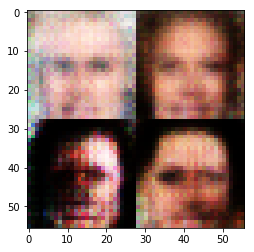

Steps 325 Discriminator Loss: 0.4878 Generator Loss: 3.4547
Steps 330 Discriminator Loss: 0.9162 Generator Loss: 0.9896
Steps 335 Discriminator Loss: 0.6178 Generator Loss: 2.3047
Steps 340 Discriminator Loss: 1.7022 Generator Loss: 0.3689


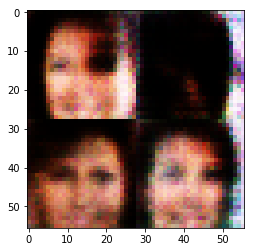

Steps 345 Discriminator Loss: 0.5738 Generator Loss: 3.4736
Steps 350 Discriminator Loss: 0.7763 Generator Loss: 1.3331
Steps 355 Discriminator Loss: 0.4672 Generator Loss: 4.0477
Steps 360 Discriminator Loss: 0.6602 Generator Loss: 2.4755


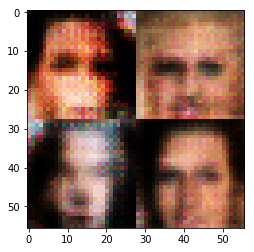

Steps 365 Discriminator Loss: 0.5068 Generator Loss: 2.8463
Steps 370 Discriminator Loss: 0.5514 Generator Loss: 2.9393
Steps 375 Discriminator Loss: 1.5242 Generator Loss: 3.9174
Steps 380 Discriminator Loss: 0.5528 Generator Loss: 2.0938


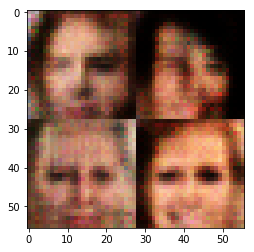

Steps 385 Discriminator Loss: 0.6787 Generator Loss: 1.4518
Steps 390 Discriminator Loss: 0.6205 Generator Loss: 1.8396
Steps 395 Discriminator Loss: 0.8994 Generator Loss: 2.2398
Steps 400 Discriminator Loss: 1.2329 Generator Loss: 0.6220


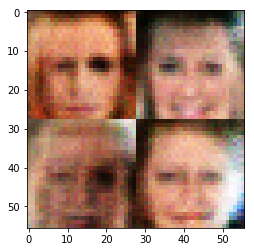

Steps 405 Discriminator Loss: 1.4618 Generator Loss: 5.2648
Steps 410 Discriminator Loss: 0.6181 Generator Loss: 1.9927
Steps 415 Discriminator Loss: 0.5317 Generator Loss: 2.1114
Steps 420 Discriminator Loss: 2.4708 Generator Loss: 0.1464


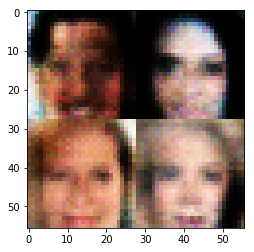

Steps 425 Discriminator Loss: 0.9336 Generator Loss: 1.2281
Steps 430 Discriminator Loss: 0.9257 Generator Loss: 1.1408
Steps 435 Discriminator Loss: 0.5466 Generator Loss: 2.2292
Steps 440 Discriminator Loss: 0.6013 Generator Loss: 2.6635


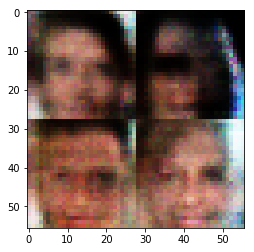

Steps 445 Discriminator Loss: 0.9574 Generator Loss: 0.9488
Steps 450 Discriminator Loss: 1.9603 Generator Loss: 0.2675
Steps 455 Discriminator Loss: 1.5647 Generator Loss: 0.4085
Steps 460 Discriminator Loss: 0.5478 Generator Loss: 1.9620


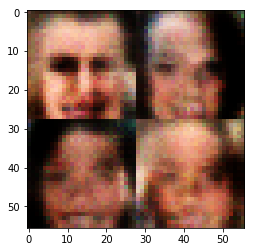

Steps 465 Discriminator Loss: 0.8165 Generator Loss: 1.1377
Steps 470 Discriminator Loss: 0.9522 Generator Loss: 1.0352
Steps 475 Discriminator Loss: 0.6805 Generator Loss: 3.9446
Steps 480 Discriminator Loss: 1.9334 Generator Loss: 0.2570


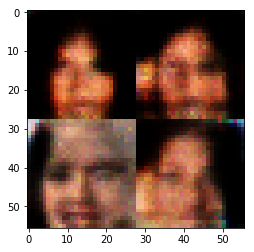

Steps 485 Discriminator Loss: 0.4795 Generator Loss: 4.1211
Steps 490 Discriminator Loss: 1.7346 Generator Loss: 1.1377
Steps 495 Discriminator Loss: 0.8580 Generator Loss: 2.2736
Steps 500 Discriminator Loss: 0.6792 Generator Loss: 2.3179


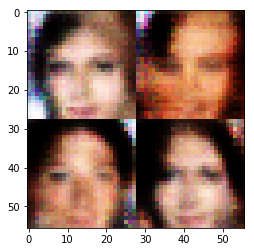

Steps 505 Discriminator Loss: 1.3299 Generator Loss: 1.6293
Steps 510 Discriminator Loss: 0.9637 Generator Loss: 2.9561
Steps 515 Discriminator Loss: 0.5274 Generator Loss: 3.3370
Steps 520 Discriminator Loss: 0.7222 Generator Loss: 1.5408


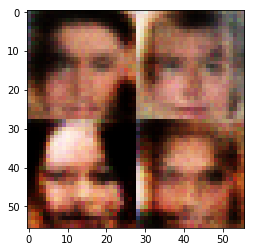

Steps 525 Discriminator Loss: 0.5564 Generator Loss: 2.3587
Steps 530 Discriminator Loss: 1.3157 Generator Loss: 0.9203
Steps 535 Discriminator Loss: 0.6049 Generator Loss: 2.1157
Steps 540 Discriminator Loss: 0.9583 Generator Loss: 1.1410


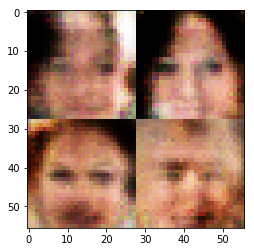

Steps 545 Discriminator Loss: 0.9589 Generator Loss: 1.2692
Steps 550 Discriminator Loss: 0.7430 Generator Loss: 1.4725
Steps 555 Discriminator Loss: 0.6707 Generator Loss: 3.2066
Steps 560 Discriminator Loss: 1.4919 Generator Loss: 0.4183


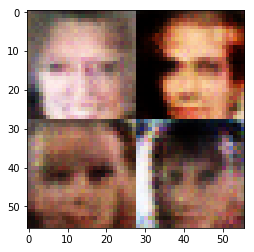

Steps 565 Discriminator Loss: 0.9280 Generator Loss: 1.7356
Steps 570 Discriminator Loss: 1.1163 Generator Loss: 1.0534
Steps 575 Discriminator Loss: 0.9921 Generator Loss: 0.8746
Steps 580 Discriminator Loss: 0.5860 Generator Loss: 2.0244


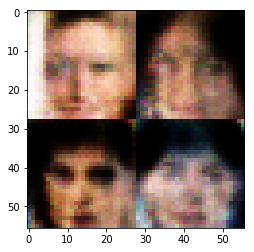

Steps 585 Discriminator Loss: 0.5810 Generator Loss: 2.0799
Steps 590 Discriminator Loss: 0.8068 Generator Loss: 1.1173
Steps 595 Discriminator Loss: 0.9488 Generator Loss: 0.9588
Steps 600 Discriminator Loss: 0.8345 Generator Loss: 2.8335


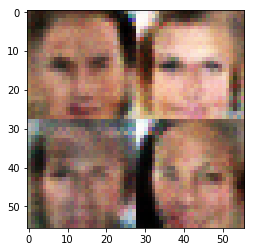

Steps 605 Discriminator Loss: 1.2148 Generator Loss: 3.4322
Steps 610 Discriminator Loss: 0.8832 Generator Loss: 2.8901
Steps 615 Discriminator Loss: 0.8468 Generator Loss: 2.9548
Steps 620 Discriminator Loss: 0.6321 Generator Loss: 3.0006


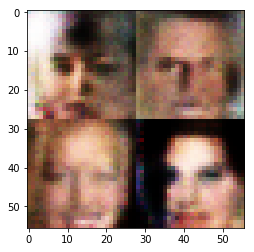

Steps 625 Discriminator Loss: 1.0910 Generator Loss: 0.8215
Steps 630 Discriminator Loss: 1.0327 Generator Loss: 2.2518
Steps 635 Discriminator Loss: 1.0412 Generator Loss: 1.4232
Steps 640 Discriminator Loss: 0.7706 Generator Loss: 1.2385


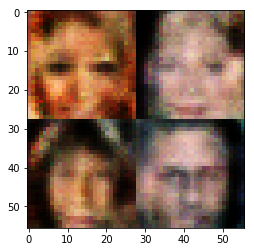

Steps 645 Discriminator Loss: 0.5318 Generator Loss: 2.4975
Steps 650 Discriminator Loss: 1.4145 Generator Loss: 0.4802
Steps 655 Discriminator Loss: 1.2999 Generator Loss: 1.3640
Steps 660 Discriminator Loss: 1.5915 Generator Loss: 0.3751


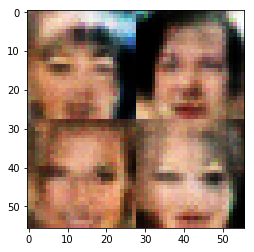

Steps 665 Discriminator Loss: 1.1922 Generator Loss: 1.7160
Steps 670 Discriminator Loss: 0.8907 Generator Loss: 1.1021
Steps 675 Discriminator Loss: 0.9072 Generator Loss: 1.0237
Steps 680 Discriminator Loss: 1.1104 Generator Loss: 2.8433


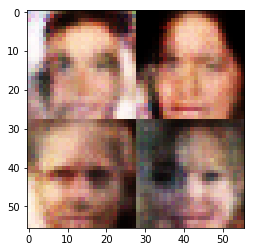

Steps 685 Discriminator Loss: 0.7272 Generator Loss: 1.4701
Steps 690 Discriminator Loss: 1.0607 Generator Loss: 4.3676
Steps 695 Discriminator Loss: 0.6548 Generator Loss: 3.0113
Steps 700 Discriminator Loss: 0.5069 Generator Loss: 2.1920


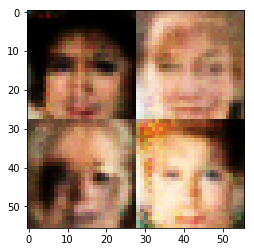

Steps 705 Discriminator Loss: 1.0350 Generator Loss: 0.7800
Steps 710 Discriminator Loss: 1.7453 Generator Loss: 0.3397
Steps 715 Discriminator Loss: 0.5270 Generator Loss: 2.2139
Steps 720 Discriminator Loss: 3.7360 Generator Loss: 2.4743


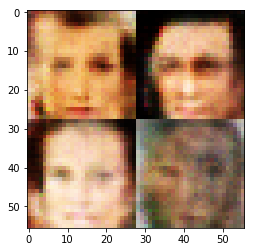

Steps 725 Discriminator Loss: 0.9606 Generator Loss: 0.9364
Steps 730 Discriminator Loss: 0.7685 Generator Loss: 2.3180
Steps 735 Discriminator Loss: 0.6493 Generator Loss: 1.9706
Steps 740 Discriminator Loss: 0.8075 Generator Loss: 1.1791


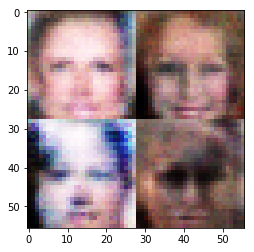

Steps 745 Discriminator Loss: 0.8010 Generator Loss: 1.4517
Steps 750 Discriminator Loss: 1.0929 Generator Loss: 3.0995
Steps 755 Discriminator Loss: 1.1758 Generator Loss: 0.7181
Steps 760 Discriminator Loss: 0.7246 Generator Loss: 1.4703


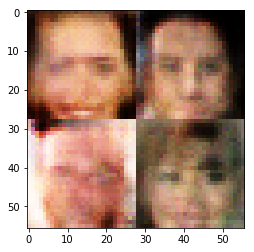

Steps 765 Discriminator Loss: 1.8348 Generator Loss: 1.1943
Steps 770 Discriminator Loss: 0.7808 Generator Loss: 1.3736
Steps 775 Discriminator Loss: 1.3489 Generator Loss: 0.5308
Steps 780 Discriminator Loss: 1.2786 Generator Loss: 1.6695


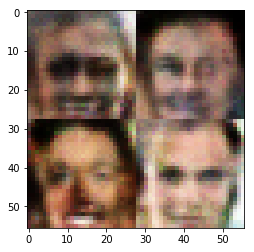

Steps 785 Discriminator Loss: 1.1954 Generator Loss: 0.9601
Steps 790 Discriminator Loss: 0.9439 Generator Loss: 1.0067
Steps 795 Discriminator Loss: 0.9464 Generator Loss: 3.5497
Steps 800 Discriminator Loss: 0.7239 Generator Loss: 1.8573


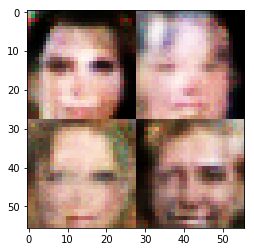

Steps 805 Discriminator Loss: 1.1977 Generator Loss: 0.9175
Steps 810 Discriminator Loss: 0.6084 Generator Loss: 1.7013
Steps 815 Discriminator Loss: 1.0147 Generator Loss: 0.8045
Steps 820 Discriminator Loss: 0.8384 Generator Loss: 1.0599


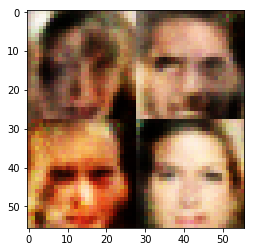

Steps 825 Discriminator Loss: 1.1271 Generator Loss: 0.6696
Steps 830 Discriminator Loss: 0.6243 Generator Loss: 1.5329
Steps 835 Discriminator Loss: 0.5633 Generator Loss: 2.6808
Steps 840 Discriminator Loss: 0.8930 Generator Loss: 0.9791


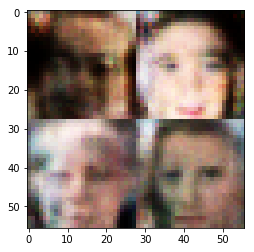

Steps 845 Discriminator Loss: 0.9640 Generator Loss: 0.9087
Steps 850 Discriminator Loss: 0.6929 Generator Loss: 2.4296
Steps 855 Discriminator Loss: 0.8422 Generator Loss: 1.0568
Steps 860 Discriminator Loss: 0.7141 Generator Loss: 1.3088


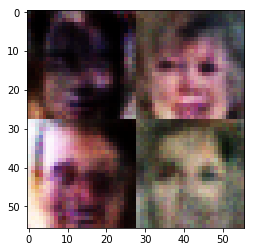

Steps 865 Discriminator Loss: 0.7823 Generator Loss: 1.1716
Steps 870 Discriminator Loss: 0.6256 Generator Loss: 1.6279
Steps 875 Discriminator Loss: 1.3283 Generator Loss: 1.5478
Steps 880 Discriminator Loss: 0.4649 Generator Loss: 3.5807


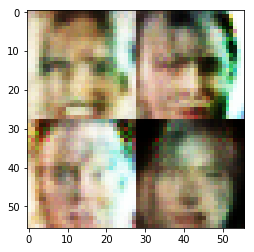

Steps 885 Discriminator Loss: 1.3343 Generator Loss: 0.9440
Steps 890 Discriminator Loss: 1.0536 Generator Loss: 0.7714
Steps 895 Discriminator Loss: 0.7941 Generator Loss: 1.5117
Steps 900 Discriminator Loss: 0.6022 Generator Loss: 1.9566


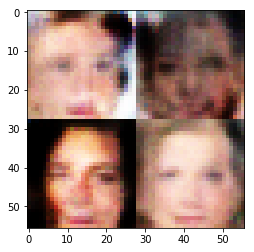

Steps 905 Discriminator Loss: 0.9749 Generator Loss: 0.8697
Steps 910 Discriminator Loss: 0.5259 Generator Loss: 2.4358
Steps 915 Discriminator Loss: 0.4777 Generator Loss: 3.2298
Steps 920 Discriminator Loss: 1.0536 Generator Loss: 0.7306


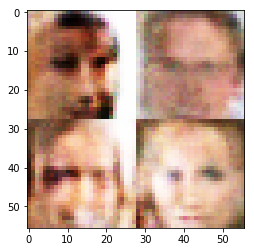

Steps 925 Discriminator Loss: 3.3819 Generator Loss: 4.5757
Steps 930 Discriminator Loss: 1.3082 Generator Loss: 1.2852
Steps 935 Discriminator Loss: 0.6880 Generator Loss: 2.8737
Steps 940 Discriminator Loss: 0.7657 Generator Loss: 1.4218


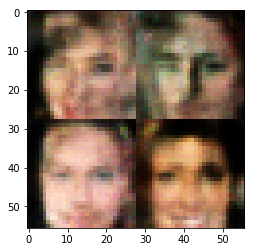

Steps 945 Discriminator Loss: 1.2262 Generator Loss: 0.7973
Steps 950 Discriminator Loss: 0.3960 Generator Loss: 3.5197
Steps 955 Discriminator Loss: 0.8565 Generator Loss: 1.2152
Steps 960 Discriminator Loss: 1.2186 Generator Loss: 0.6241


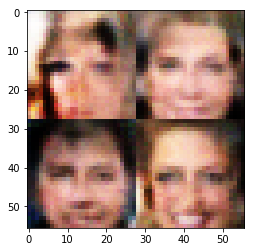

Steps 965 Discriminator Loss: 0.8807 Generator Loss: 1.1694
Steps 970 Discriminator Loss: 0.6771 Generator Loss: 1.6563
Steps 975 Discriminator Loss: 1.2291 Generator Loss: 0.6191
Steps 980 Discriminator Loss: 1.6192 Generator Loss: 1.9779


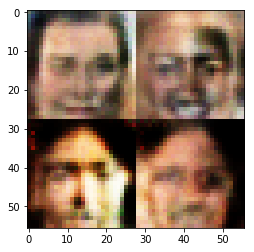

Steps 985 Discriminator Loss: 1.4909 Generator Loss: 0.5753
Steps 990 Discriminator Loss: 1.1906 Generator Loss: 0.7606
Steps 995 Discriminator Loss: 0.7869 Generator Loss: 1.5566
Steps 1000 Discriminator Loss: 0.6731 Generator Loss: 1.9716


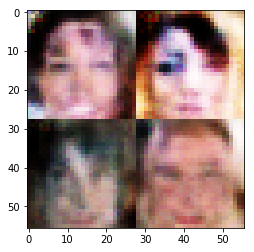

Steps 1005 Discriminator Loss: 0.4367 Generator Loss: 3.2742
Steps 1010 Discriminator Loss: 0.8478 Generator Loss: 2.2032
Steps 1015 Discriminator Loss: 0.5382 Generator Loss: 3.3857
Steps 1020 Discriminator Loss: 0.6569 Generator Loss: 3.7054


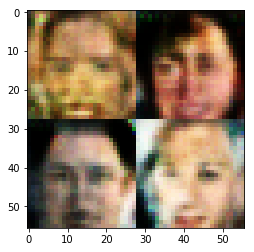

Steps 1025 Discriminator Loss: 0.6162 Generator Loss: 2.9576
Steps 1030 Discriminator Loss: 0.9660 Generator Loss: 1.0649
Steps 1035 Discriminator Loss: 0.6340 Generator Loss: 3.1033
Steps 1040 Discriminator Loss: 0.7101 Generator Loss: 1.7406


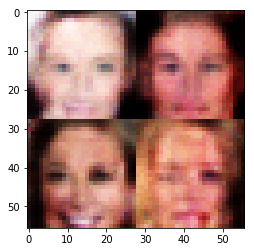

Steps 1045 Discriminator Loss: 1.6031 Generator Loss: 1.7528
Steps 1050 Discriminator Loss: 0.6437 Generator Loss: 2.7403
Steps 1055 Discriminator Loss: 0.9091 Generator Loss: 1.1899
Steps 1060 Discriminator Loss: 0.6807 Generator Loss: 1.7251


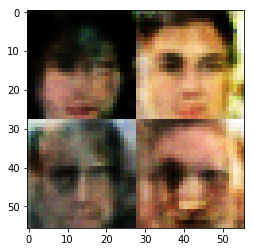

Steps 1065 Discriminator Loss: 1.0806 Generator Loss: 0.7400
Steps 1070 Discriminator Loss: 0.5999 Generator Loss: 2.9175
Steps 1075 Discriminator Loss: 0.7477 Generator Loss: 1.6590
Steps 1080 Discriminator Loss: 1.7609 Generator Loss: 0.3232


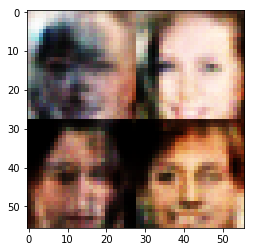

Steps 1085 Discriminator Loss: 0.5823 Generator Loss: 2.5218
Steps 1090 Discriminator Loss: 0.4189 Generator Loss: 3.8750
Steps 1095 Discriminator Loss: 0.7443 Generator Loss: 1.3141
Steps 1100 Discriminator Loss: 0.6699 Generator Loss: 1.4990


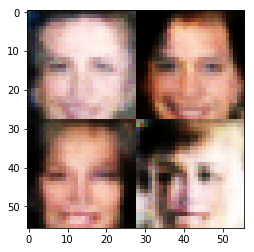

Steps 1105 Discriminator Loss: 1.0165 Generator Loss: 3.0091
Steps 1110 Discriminator Loss: 0.8642 Generator Loss: 3.3806
Steps 1115 Discriminator Loss: 0.8812 Generator Loss: 1.2055
Steps 1120 Discriminator Loss: 0.6686 Generator Loss: 2.3580


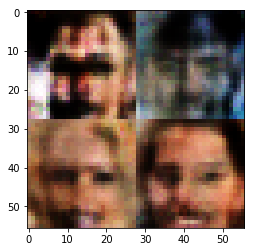

Steps 1125 Discriminator Loss: 0.9251 Generator Loss: 1.1919
Steps 1130 Discriminator Loss: 0.5801 Generator Loss: 3.4199
Steps 1135 Discriminator Loss: 1.2739 Generator Loss: 0.7086
Steps 1140 Discriminator Loss: 1.3975 Generator Loss: 0.6898


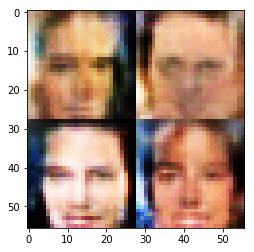

Steps 1145 Discriminator Loss: 1.4381 Generator Loss: 0.4869
Steps 1150 Discriminator Loss: 0.8604 Generator Loss: 1.0793
Steps 1155 Discriminator Loss: 0.8145 Generator Loss: 2.0151
Steps 1160 Discriminator Loss: 0.7280 Generator Loss: 1.4901


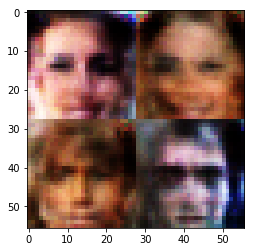

Steps 1165 Discriminator Loss: 0.9892 Generator Loss: 0.8530
Steps 1170 Discriminator Loss: 0.7037 Generator Loss: 1.5010
Steps 1175 Discriminator Loss: 0.7953 Generator Loss: 1.9562
Steps 1180 Discriminator Loss: 1.0992 Generator Loss: 1.5806


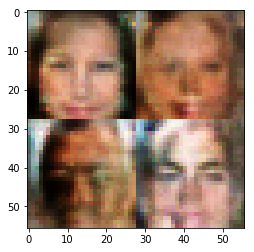

Steps 1185 Discriminator Loss: 0.7174 Generator Loss: 1.5660
Steps 1190 Discriminator Loss: 1.0150 Generator Loss: 0.7835
Steps 1195 Discriminator Loss: 0.7704 Generator Loss: 2.4755
Steps 1200 Discriminator Loss: 0.6511 Generator Loss: 3.6038


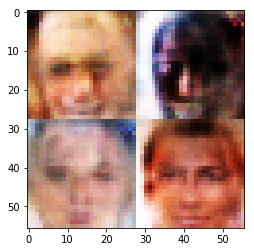

Steps 1205 Discriminator Loss: 1.0148 Generator Loss: 1.4216
Steps 1210 Discriminator Loss: 1.6906 Generator Loss: 0.3485
Steps 1215 Discriminator Loss: 1.1631 Generator Loss: 0.6968
Steps 1220 Discriminator Loss: 0.6511 Generator Loss: 2.0876


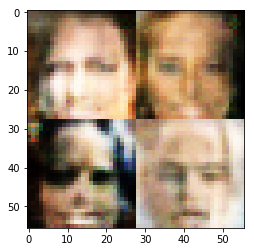

Steps 1225 Discriminator Loss: 0.8690 Generator Loss: 1.5901
Steps 1230 Discriminator Loss: 1.0280 Generator Loss: 2.8276
Steps 1235 Discriminator Loss: 0.7808 Generator Loss: 1.4316
Steps 1240 Discriminator Loss: 0.9874 Generator Loss: 1.5558


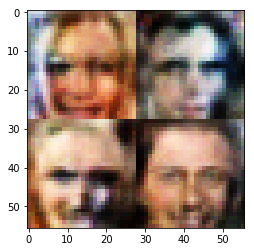

Steps 1245 Discriminator Loss: 0.9896 Generator Loss: 0.8554
Steps 1250 Discriminator Loss: 0.6718 Generator Loss: 2.7419
Steps 1255 Discriminator Loss: 0.9126 Generator Loss: 0.9686
Steps 1260 Discriminator Loss: 0.5192 Generator Loss: 2.0379


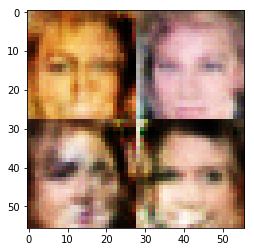

Steps 1265 Discriminator Loss: 0.6112 Generator Loss: 1.5897
Steps 1270 Discriminator Loss: 0.5924 Generator Loss: 1.7432
Steps 1275 Discriminator Loss: 0.6518 Generator Loss: 2.2549
Steps 1280 Discriminator Loss: 0.6785 Generator Loss: 1.4363


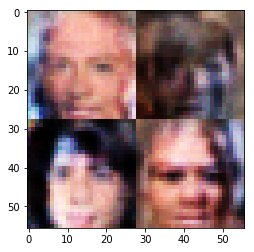

Steps 1285 Discriminator Loss: 0.7894 Generator Loss: 1.7440
Steps 1290 Discriminator Loss: 2.0796 Generator Loss: 0.2398
Steps 1295 Discriminator Loss: 0.5674 Generator Loss: 1.9443
Steps 1300 Discriminator Loss: 0.6409 Generator Loss: 3.4827


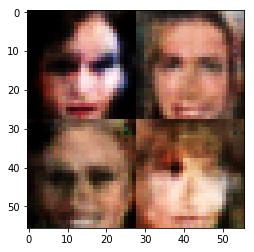

Steps 1305 Discriminator Loss: 0.4976 Generator Loss: 2.2098
Steps 1310 Discriminator Loss: 1.3313 Generator Loss: 3.1838
Steps 1315 Discriminator Loss: 1.2770 Generator Loss: 0.7064
Steps 1320 Discriminator Loss: 0.6614 Generator Loss: 1.5821


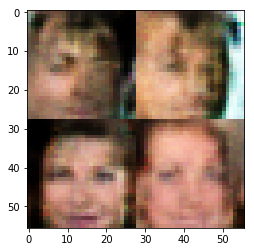

Steps 1325 Discriminator Loss: 0.5797 Generator Loss: 2.3944
Steps 1330 Discriminator Loss: 0.7762 Generator Loss: 1.1798
Steps 1335 Discriminator Loss: 0.4969 Generator Loss: 2.2748
Steps 1340 Discriminator Loss: 1.5775 Generator Loss: 0.4013


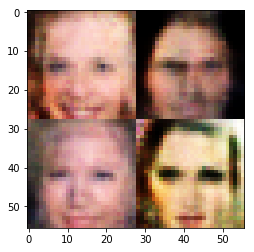

Steps 1345 Discriminator Loss: 0.9407 Generator Loss: 1.2536
Steps 1350 Discriminator Loss: 0.5698 Generator Loss: 1.9746
Steps 1355 Discriminator Loss: 0.5167 Generator Loss: 2.3800
Steps 1360 Discriminator Loss: 0.4741 Generator Loss: 2.6723


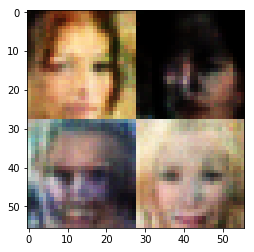

Steps 1365 Discriminator Loss: 0.7427 Generator Loss: 1.3821
Steps 1370 Discriminator Loss: 0.7044 Generator Loss: 1.3806
Steps 1375 Discriminator Loss: 0.6407 Generator Loss: 3.1917
Steps 1380 Discriminator Loss: 0.8567 Generator Loss: 1.4871


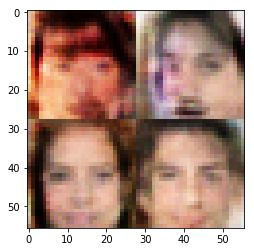

Steps 1385 Discriminator Loss: 0.6821 Generator Loss: 2.1431
Steps 1390 Discriminator Loss: 0.6833 Generator Loss: 1.4357
Steps 1395 Discriminator Loss: 0.8090 Generator Loss: 1.1471
Steps 1400 Discriminator Loss: 0.4297 Generator Loss: 2.9308


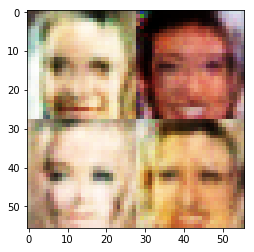

Steps 1405 Discriminator Loss: 0.8610 Generator Loss: 1.1982
Steps 1410 Discriminator Loss: 1.5758 Generator Loss: 3.0895
Steps 1415 Discriminator Loss: 1.0190 Generator Loss: 1.3507
Steps 1420 Discriminator Loss: 0.5865 Generator Loss: 1.9745


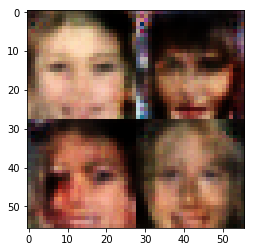

Steps 1425 Discriminator Loss: 0.5037 Generator Loss: 2.8377
Steps 1430 Discriminator Loss: 1.4535 Generator Loss: 0.4770
Steps 1435 Discriminator Loss: 1.1086 Generator Loss: 0.7167
Steps 1440 Discriminator Loss: 1.5225 Generator Loss: 0.4788


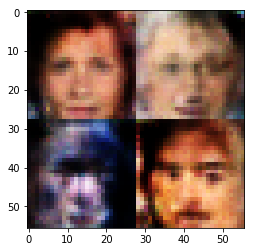

Steps 1445 Discriminator Loss: 1.0342 Generator Loss: 1.0125
Steps 1450 Discriminator Loss: 0.4803 Generator Loss: 3.1154
Steps 1455 Discriminator Loss: 1.2368 Generator Loss: 0.5926
Steps 1460 Discriminator Loss: 0.5367 Generator Loss: 2.1043


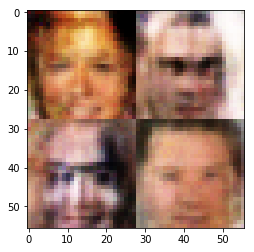

Steps 1465 Discriminator Loss: 0.5926 Generator Loss: 1.7804
Steps 1470 Discriminator Loss: 0.7388 Generator Loss: 1.7621
Steps 1475 Discriminator Loss: 0.9710 Generator Loss: 1.0563
Steps 1480 Discriminator Loss: 0.5889 Generator Loss: 3.8700


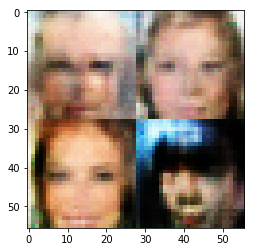

Steps 1485 Discriminator Loss: 0.7298 Generator Loss: 2.9154
Steps 1490 Discriminator Loss: 1.4977 Generator Loss: 0.4533
Steps 1495 Discriminator Loss: 0.5999 Generator Loss: 1.8385
Steps 1500 Discriminator Loss: 0.7474 Generator Loss: 4.5070


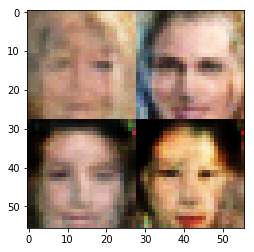

Steps 1505 Discriminator Loss: 0.4389 Generator Loss: 4.1409
Steps 1510 Discriminator Loss: 0.7172 Generator Loss: 2.2678
Steps 1515 Discriminator Loss: 1.0932 Generator Loss: 2.3014
Steps 1520 Discriminator Loss: 2.0555 Generator Loss: 2.7902


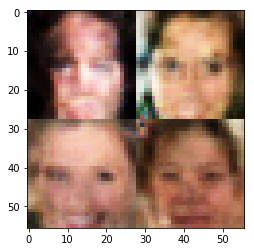

Steps 1525 Discriminator Loss: 0.9326 Generator Loss: 1.4638
Steps 1530 Discriminator Loss: 0.9932 Generator Loss: 0.8888
Steps 1535 Discriminator Loss: 1.0563 Generator Loss: 4.5089
Steps 1540 Discriminator Loss: 0.6919 Generator Loss: 1.4031


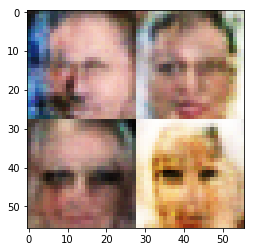

Steps 1545 Discriminator Loss: 0.8086 Generator Loss: 1.6139
Steps 1550 Discriminator Loss: 0.5358 Generator Loss: 2.2300
Steps 1555 Discriminator Loss: 0.6220 Generator Loss: 1.7583
Steps 1560 Discriminator Loss: 0.5973 Generator Loss: 3.0967


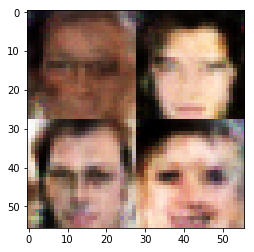

Steps 1565 Discriminator Loss: 0.8413 Generator Loss: 2.3421
Steps 1570 Discriminator Loss: 1.1665 Generator Loss: 0.7151
Steps 1575 Discriminator Loss: 0.7521 Generator Loss: 1.2957
Steps 1580 Discriminator Loss: 1.5174 Generator Loss: 0.4546


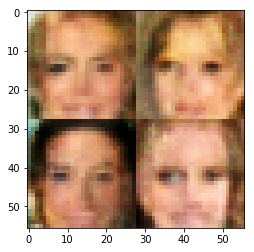

Finished Training. The result: 


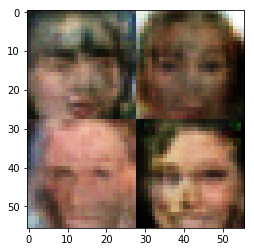

In [16]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.